In [1]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, make_scorer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score
import pickle


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('../data/processed/dataset_processed.csv')
df.head()

,average_cyclomatic_complexity,average_methods_per_class,avg_line_length,boolean_expression_avg_terms,call_graph_density,classes,classes_with_inheritance,comment_code_mismatch_score,comment_lines,comment_percentage,decision_density,documentation_coverage,external_vs_internal_field_access_ratio,file_age_days,file_path,functions,global_usages_total,globals_declared,halstead_difficulty,halstead_effort,halstead_estimated_bugs,halstead_volume,inter_file_coupling,large_parameter_list_indicator,lazy_class_indicator,lines_added,lines_of_code,long_method_indicator,max_cyclomatic_ratio,max_intra_file_call_depth,max_line_length,max_lines_per_function,max_nesting_level,mean_cyclomatic_ratio,mean_lines_per_function,mean_param_entropy,methods,nesting_variance,num_authors,pep8_violations,percent_lines_over_80,semantic_todo_density,source_lines,test_files_found,test_function_count,test_lines,test_to_source_ratio,todo_fixme_count,todo_fixme_semantic_density,total_imports,unit_test_presence,y_FeatureEnvy,y_FormattingIssues,y_GlobalStateAbuse,y_GodClass,y_LargeParameterList,y_LazyClass,y_LongMethod,y_MisleadingComments,y_PoorDocumentation,y_SpaghettiCode,y_UnstableModule,y_UntestedCode,y_any_smell
0,0.360756,0.0,0.394464,0.0,0.333333,0.00000,0.000,0.0,0.125000,0.167,0.623314,0.0,0.033846,0.0,awesome-python\sort.py,0.025974,0.00000,0.000000,0.101876,0.010526,0.026215,0.026210,0.105263,False,False,0.011375,0.011375,False,0.172667,0.125,0.115646,0.005102,0.3,0.254697,0.118520,0.000000,0.0,0.12288,0.0,0.002972,0.035704,0.0,0.006111,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1,0,0,0,0,0,0,0,1,0,0,1,1
1,0.166203,0.0,0.369089,0.0,0.000000,0.00000,0.000,0.0,0.017857,0.095,0.326629,0.0,0.009231,0.0,fastapi\pdm_build.py,0.012987,0.00625,0.038462,0.000000,0.000000,0.000000,0.000000,0.017544,False,False,0.002741,0.002741,False,0.166667,0.000,0.083900,0.001749,0.1,0.260960,0.045879,0.613327,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.001944,1.0,1.0,1.0,0.071766,0.0,0.0,0.038961,0.0,0,0,0,0,1,0,0,0,1,0,0,0,1
2,0.110617,0.0,0.242215,0.0,0.000000,0.04878,0.050,0.0,0.000000,0.000,0.163200,0.0,0.003077,0.0,fastapi\docs_src\additional_responses\tutorial...,0.000000,0.00625,0.038462,0.000000,0.000000,0.000000,0.000000,0.017544,False,False,0.003015,0.003015,False,0.333333,0.000,0.097506,0.000583,0.1,0.521921,0.015293,0.613327,0.0,0.00000,0.0,0.001486,0.130513,0.0,0.001944,0.0,0.0,0.0,0.000000,0.0,0.0,0.038961,0.0,0,1,0,0,0,1,0,0,1,0,0,0,1
3,0.110617,0.0,0.226067,0.0,0.000000,0.02439,0.025,0.0,0.000000,0.000,0.104000,0.0,0.003077,0.0,fastapi\docs_src\additional_responses\tutorial...,0.000000,0.00625,0.038462,0.021992,0.000387,0.004495,0.004494,0.017544,False,False,0.003837,0.003837,False,0.266667,0.000,0.072562,0.000729,0.1,0.417537,0.019116,0.643482,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.003056,0.0,0.0,0.0,0.000000,0.0,0.0,0.038961,0.0,0,0,0,0,0,1,0,0,1,0,0,0,1
4,0.110617,0.0,0.222607,0.0,0.000000,0.02439,0.025,0.0,0.000000,0.000,0.099429,0.0,0.003077,0.0,fastapi\docs_src\additional_responses\tutorial...,0.000000,0.00625,0.038462,0.000000,0.000000,0.000000,0.000000,0.017544,False,False,0.004111,0.004111,False,0.266667,0.000,0.073696,0.000729,0.1,0.417537,0.019116,0.643482,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.003194,0.0,0.0,0.0,0.000000,0.0,0.0,0.051948,0.0,0,0,0,0,0,1,0,0,1,0,0,0,1


In [4]:
X = df.iloc[:, :51].drop(columns=['file_path'])
y = df.iloc[:, 51:]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [5]:
param_dist = {
    "estimator__n_estimators": [100, 200, 300],
    "estimator__max_depth": [None, 20, 40],
    "estimator__min_samples_split": [2, 5],
    "estimator__min_samples_leaf": [1, 2]
}

base_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

model = MultiOutputClassifier(base_model)


In [6]:
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring="f1_micro",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
best_params = random_search.best_params_


Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END estimator__max_depth=40, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   4.7s
[CV] END estimator__max_depth=20, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   4.6s
[CV] END estimator__max_depth=40, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   4.7s
[CV] END estimator__max_depth=20, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   4.8s
[CV] END estimator__max_depth=40, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   4.9s
[CV] END estimator__max_depth=40, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=200; total time=   8.2s
[CV] END estimator__max_depth=20, estimator__min_samples_leaf=1, esti

In [7]:
print("Best CV micro-F1 (Random Search):", random_search.best_score_)
print("Best parameters:", best_params)

Best CV micro-F1 (Random Search): 0.9821950732384757
Best parameters: {'estimator__n_estimators': 300, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 1, 'estimator__max_depth': 40}


In [8]:
Y_pred = best_model.predict(X_test)

print("Test micro-F1:", f1_score(y_test, Y_pred, average="micro"))
print(classification_report(y_test, Y_pred, target_names=y.columns))

Test micro-F1: 0.9819940876108573
                      precision    recall  f1-score   support

       y_FeatureEnvy       0.99      0.99      0.99       320
  y_FormattingIssues       0.91      0.85      0.88       368
  y_GlobalStateAbuse       1.00      0.98      0.99        49
          y_GodClass       0.91      0.75      0.82        40
y_LargeParameterList       1.00      1.00      1.00       520
         y_LazyClass       0.99      0.99      0.99       137
        y_LongMethod       1.00      0.99      0.99       215
y_MisleadingComments       1.00      1.00      1.00       327
 y_PoorDocumentation       1.00      1.00      1.00       587
     y_SpaghettiCode       1.00      0.84      0.91        31
    y_UnstableModule       1.00      1.00      1.00        20
      y_UntestedCode       1.00      1.00      1.00       319
         y_any_smell       0.98      1.00      0.99       803

           micro avg       0.99      0.98      0.98      3736
           macro avg       0.98   

In [9]:
grid_param_dist = {
    "estimator__n_estimators": [
        best_params["estimator__n_estimators"] - 100,
        best_params["estimator__n_estimators"],
        best_params["estimator__n_estimators"] + 100
    ],
    "estimator__max_depth": (
    [best_params["estimator__max_depth"]]
    if best_params["estimator__max_depth"] is None
    else [best_params["estimator__max_depth"] - 10,
          best_params["estimator__max_depth"],
          best_params["estimator__max_depth"] + 10]
),
    "estimator__min_samples_split": [
        best_params["estimator__min_samples_split"]
    ],
    "estimator__min_samples_leaf": [
        best_params["estimator__min_samples_leaf"]
    ]
}

grid_search = GridSearchCV(
    estimator = model,
    param_grid = grid_param_dist,
    cv=3,
    scoring="f1_micro",
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
final_model = grid_search.best_estimator_



Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END estimator__max_depth=50, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=200; total time=   8.8s
[CV] END estimator__max_depth=40, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=200; total time=   9.0s
[CV] END estimator__max_depth=30, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=200; total time=   9.2s
[CV] END estimator__max_depth=30, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=200; total time=   9.2s
[CV] END estimator__max_depth=40, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=200; total time=   9.3s
[CV] END estimator__max_depth=50, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=200; total time=   9.5s
[CV] END estimator__max_depth=40, estimator__min_samples_leaf=1, estim

In [10]:
print("Refined CV micro-F1 (Grid Search):", grid_search.best_score_)
print("Refined best parameters:", grid_search.best_params_)

Refined CV micro-F1 (Grid Search): 0.9821950732384757
Refined best parameters: {'estimator__max_depth': 30, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 300}


In [11]:
Y_pred = final_model.predict(X_test)

print("Test micro-F1:",
      f1_score(y_test, Y_pred, average="micro"))
print(classification_report(y_test, Y_pred, target_names=y.columns))

Test micro-F1: 0.9819940876108573
                      precision    recall  f1-score   support

       y_FeatureEnvy       0.99      0.99      0.99       320
  y_FormattingIssues       0.91      0.85      0.88       368
  y_GlobalStateAbuse       1.00      0.98      0.99        49
          y_GodClass       0.91      0.75      0.82        40
y_LargeParameterList       1.00      1.00      1.00       520
         y_LazyClass       0.99      0.99      0.99       137
        y_LongMethod       1.00      0.99      0.99       215
y_MisleadingComments       1.00      1.00      1.00       327
 y_PoorDocumentation       1.00      1.00      1.00       587
     y_SpaghettiCode       1.00      0.84      0.91        31
    y_UnstableModule       1.00      1.00      1.00        20
      y_UntestedCode       1.00      1.00      1.00       319
         y_any_smell       0.98      1.00      0.99       803

           micro avg       0.99      0.98      0.98      3736
           macro avg       0.98   

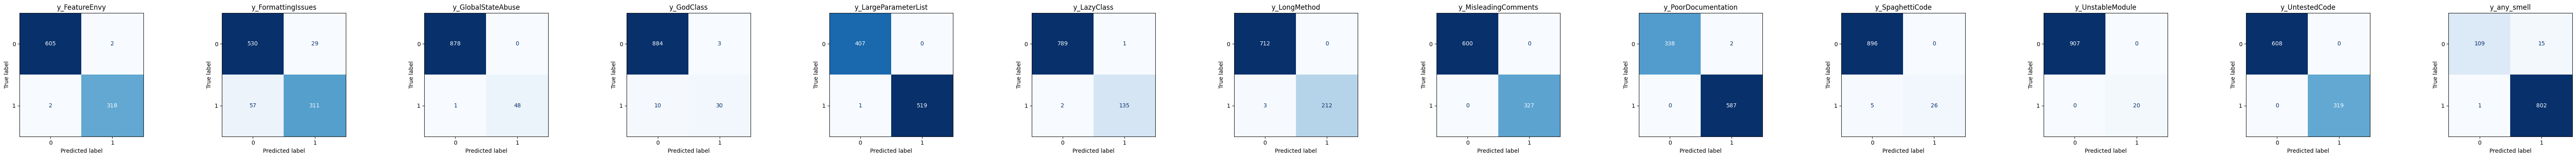

In [12]:
# Confusion Matrix Visualization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(1, len(y.columns), figsize=(5 * len(y.columns), 4))
if len(y.columns) == 1:
    axes = [axes]

for i, col in enumerate(y.columns):
    cm = confusion_matrix(y_test[col], Y_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
    disp.plot(ax=axes[i], cmap="Blues", colorbar=False)
    axes[i].set_title(col)

plt.tight_layout()
plt.savefig("../models/random_forest_confusion_matrix.png", dpi=150)
plt.show()

In [13]:
with open("../models/random_forest.pkl", "wb") as f:
    pickle.dump(final_model, f)

print("Tuned Random Forest model saved successfully!")


Tuned Random Forest model saved successfully!
